In [1]:
import numpy as np
import itertools

# ------------------------
# Parameters
# ------------------------
degree_theta = 1.0  # Example twist angle (deg)

hbar = 0.6582  # (eV*fs)
m0 = 5.68568  # (eV fs² nm⁻²)

me = 0.43 * m0
phi = 128 * (np.pi / 180)
V0 = 0.009
w = 0.018
a = 0.3317
theta = degree_theta * (np.pi / 180)

# Moiré lattice constant
aM = a / (2.0 * np.sin(0.5 * theta))

# g-vectors of mBZ
g0 = (4 * np.pi) / (np.sqrt(3) * aM)
q0 = g0 / np.sqrt(3)
gvecs = g0 * np.array([[np.cos(n * np.pi / 3), np.sin(n * np.pi / 3)] for n in range(6)])
Ktop = (gvecs[0] + gvecs[5]) / 3.0
Kbot = (gvecs[0] + gvecs[1]) / 3.0
g1 = gvecs[0]
g2 = gvecs[1]

# Moiré shells
Nshells = 4
Nzf = (2 * Nshells + 1) ** 2
map_zf_idx = list(itertools.product(range(-Nshells, Nshells + 1),
                                    range(-Nshells, Nshells + 1)))
Nbands = Nzf * 2  # 2 layers 

# ------------------------
# Functions (unchanged logic)
# ------------------------
def compute_H(k):
    H = np.zeros((Nbands, Nbands), dtype=complex)

    for n1 in range(Nzf):
        n11, n12 = map_zf_idx[n1]
        i1_t = 2 * n1
        i1_b = i1_t + 1

        km_t = np.linalg.norm(k + n11 * g1 + n12 * g2 - Ktop)
        km_b = np.linalg.norm(k + n11 * g1 + n12 * g2 - Kbot)

        # Kinetic energy (note the square!)
        H[i1_t, i1_t] = hbar**2 * km_t**2 / (2 * me)
        H[i1_b, i1_b] = hbar**2 * km_b**2 / (2 * me)

        # Tunneling (q=0)
        H[i1_t, i1_b] = w
        H[i1_b, i1_t] = w

        for n2 in range(Nzf):
            n21, n22 = map_zf_idx[n2]
            i2_t = 2 * n2
            i2_b = i2_t + 1

            if (n21 == n11 + 1) and (n22 == n12):
                # g1
                H[i1_t, i2_t] = -V0 * np.exp(1j * phi)
                H[i1_b, i2_b] = -V0 * np.exp(-1j * phi)
                # g4 (Hermitian counterpart)
                H[i2_t, i1_t] = -V0 * np.exp(-1j * phi)
                H[i2_b, i1_b] = -V0 * np.exp(1j * phi)

            elif (n21 == n11) and (n22 == n12 + 1):
                # g2
                H[i1_t, i2_t] = -V0 * np.exp(-1j * phi)
                H[i1_b, i2_b] = -V0 * np.exp(1j * phi)
                H[i1_t, i2_b] = w  # momentum-shifted tunneling
                # g5
                H[i2_t, i1_t] = -V0 * np.exp(1j * phi)
                H[i2_b, i1_b] = -V0 * np.exp(-1j * phi)
                H[i2_b, i1_t] = w

            elif (n21 == n11 - 1) and (n22 == n12 + 1):
                # g3
                H[i1_t, i2_t] = -V0 * np.exp(1j * phi)
                H[i1_b, i2_b] = -V0 * np.exp(-1j * phi)
                H[i1_t, i2_b] = w
                # g6
                H[i2_t, i1_t] = -V0 * np.exp(-1j * phi)
                H[i2_b, i1_b] = -V0 * np.exp(1j * phi)
                H[i2_b, i1_t] = w

    return H


def solve_H(k):
    H = compute_H(k)
    eigenvalues, eigenvectors = np.linalg.eigh(H)
    Ek = np.real(eigenvalues)
    WF = eigenvectors
    return Ek, WF

def calculate_bandstructure():
    Nk1 = 100
    Nk2 = 50
    Nk3 = 100
    Nk = Nk1 + Nk2 + Nk3
    
    kvec = []
    Gamma = np.array([0, 0])
    for n in range(Nk1):
        kvec.append(Gamma + (Ktop - Gamma) * (n / Nk1))
    Mpoint = 0.5 * (Ktop + Kbot)
    for n in range(Nk2):
        kvec.append(Ktop + (Mpoint - Ktop) * (n / Nk2))
    for n in range(Nk3):
        kvec.append(Mpoint + (Gamma - Mpoint) * (n / Nk3))

    kvec = np.array(kvec)

    Ek = np.zeros((Nbands, Nk))
    WF = None
    for nk in range(Nk):
        Ek[:, nk], WF = solve_H(kvec[nk, :]) #Structure of this is that index 0 is the band index and the rest are the momentum positioning

    bz_points = [0, Nk1, Nk1 + Nk2, Nk]

    return Ek, WF, bz_points, Nk

Ek, WF, bz_points, Nk = calculate_bandstructure()

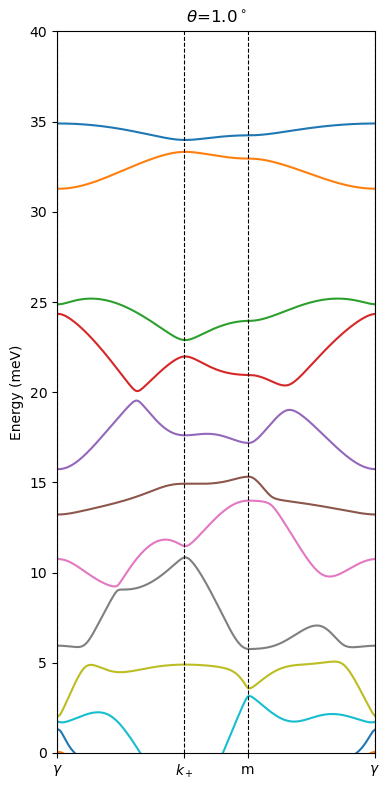

In [2]:
import matplotlib.pyplot as plt

def plot_single_bandstructure(degree_theta, Ek):
    
    # Plot first 15 bands with negative energies in meV
    plt.figure(figsize=(4, 8))
    for n in range(25):  # First 15 bands
        plt.plot(range(1, Nk + 1), -Ek[n, :])  # Convert to meV and negate
        
    # BZ point labels
    labels = ["$\gamma$", "$k_+$", "m", "$\gamma$"]
    
    # Vertical dotted lines at BZ points (except start and end)
    for pos in bz_points:
        plt.axvline(x=pos, color='k', linestyle='--', linewidth=0.8)
    
    # Label BZ points
    plt.xticks(bz_points, labels)
    plt.xlabel("")
    
    # Set limits
    plt.xlim(0, Nk)
    plt.ylim(0, 40)
    
    plt.ylabel("Energy (meV)")
    plt.title(rf"$\theta$={degree_theta}$^\circ$")
    plt.tight_layout()
    plt.show()

plot_single_bandstructure(degree_theta, Ek*1e3)

In [3]:
# Define k-grid in mBZ (map hexagon into square)
Nkx = 21 # Number of points in x direction
Nky = 21
band = 0

# kxvec = np.linspace(g1[0], g2[0], Nkx)
# kyvec = np.linspace(g1[1], g2[1], Nky)
# dkx = kxvec[1] - kxvec[0]
# dky = kyvec[1] - kyvec[0]

WF = np.zeros((Nbands, Nkx, Nky), dtype=complex)
for nkx in range(Nkx):
    for nky in range(Nkx):
        #k = [kxvec[nkx],kyvec[nky]]
        k = ((nkx-1)/(Nkx-1))*g1 + ((nky-1)/(Nky-1))*g2
        _, WF_hlp = solve_H(k)
        #E[:,nkx,nky] = real.([F.values[band], F.values[band+1]])
        WF[:,nkx,nky] = WF_hlp[:,band]


Berry_curvature = np.zeros((Nkx - 1, Nky - 1))
for nkx in range(Nkx - 1):
    for nky in range(Nky - 1):
        #Ux  = np.vdot(WF[:, nkx, nky], WF[:, nkx + 1, nky])  
        Ux  = np.sum(np.conj(WF[n, nkx, nky]) * WF[n, nkx + 1, nky] for n in range(len(WF[:, nkx, nky])))
        Ux  = Ux / np.abs(Ux)    # <WF(k)|WF(k+dx)>
        
        #Uy  = np.vdot(WF[:, nkx, nky], WF[:, nkx, nky + 1])      # <WF(k)|WF(k+dy)>
        Uy  = np.sum(np.conj(WF[n, nkx, nky]) * WF[n, nkx, nky+1] for n in range(len(WF[:, nkx, nky])))
        Uy  = Uy / np.abs(Uy) 

        #Uxy = np.vdot(WF[:, nkx + 1, nky], WF[:, nkx + 1, nky + 1]) # < WF(k+dx)|WF(k+dy+dx)>
        Uxy  = np.sum(np.conj(WF[n, nkx+1, nky]) * WF[n, nkx+1, nky+1] for n in range(len(WF[:, nkx, nky])))
        Uxy  = Uxy / np.abs(Uxy) 

        #Uyx = np.vdot(WF[:, nkx, nky + 1], WF[:, nkx + 1, nky + 1]) # <WF(k+dy)|WF(k+dy+dx)>
        Uyx  = np.sum(np.conj(WF[n, nkx, nky + 1]) * WF[n, nkx+1, nky+1] for n in range(len(WF[:, nkx, nky])))
        Uyx  = Uyx / np.abs(Uyx) 

        # Ux = np.sum(np.conj(WF[:, nkx, nky]) * WF[:, nkx+1, nky])
        # Uy = np.sum(np.conj(WF[:, nkx, nky]) * WF[:, nkx, nky+1])
        # Uxy = np.sum(np.conj(WF[:, nkx+1, nky]) * WF[:, nkx+1, nky+1])
        # Uyx = np.sum(np.conj(WF[:, nkx, nky+1]) * WF[:, nkx+1, nky+1])
        
        # Ensure phase ∈ [-π, π]
        phase = np.real((1/1.0j)*np.log(Ux * Uxy / (Uyx * Uy)))
        #phase = np.mod(phase + np.pi, 2 * np.pi) - np.pi

        Berry_curvature[nkx, nky] = phase 

chernnum = np.sum(Berry_curvature) / (2 * np.pi)

print(f"Chern number: {chernnum}")


/tmp/ipykernel_399/334026549.py:25: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  Ux  = np.sum(np.conj(WF[n, nkx, nky]) * WF[n, nkx + 1, nky] for n in range(len(WF[:, nkx, nky])))
/tmp/ipykernel_399/334026549.py:29: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  Uy  = np.sum(np.conj(WF[n, nkx, nky]) * WF[n, nkx, nky+1] for n in range(len(WF[:, nkx, nky])))
/tmp/ipykernel_399/334026549.py:33: DeprecationWarning: Calling np.sum(generator) is deprecated, and in the future will give a different result. Use np.sum(np.fromiter(generator)) or the python sum builtin instead.
  Uxy  = np.sum(np.conj(WF[n, nkx+1, nky]) * WF[n, nkx+1, nky+1] for n in range(len(WF[:, nkx, nky])))
/tmp/ipykernel_399/334026549.py:37: DeprecationWarning

Chern number: 1.0000555421427613


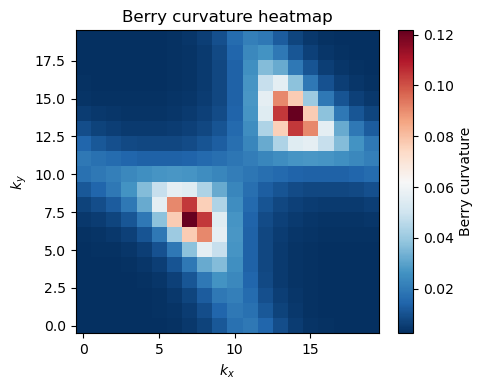

In [4]:
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 4))
plt.imshow(Berry_curvature.T, origin="lower", cmap="RdBu_r")
plt.colorbar(label="Berry curvature")
plt.xlabel(r"$k_x$")
plt.ylabel(r"$k_y$")
plt.title("Berry curvature heatmap")
plt.tight_layout()
plt.show()